# Model Inference Notebook

This notebook load a computer vision model using PyTorch.  
It loads the dataset, initializes the model, trains it, visualizes metrics,  
and evaluates it on a validation set.

The workflow:
1. Import libraries
2. Load Hyperparameters and Initialize the Model
3. Load Test Images
4. Define Class Names and Load Dataset Statistics
5. Preprocess Images and Build a Batch
6. Run Inference and Print Top-1 Predictions
7. Visualize Images with Top-1 Predictions
8. Visualize Images with Top-3 Predictions

## Step 1 – Import libraries
We start by importing all required packages and modules for training and evaluation.

In [1]:
import torch
from torchvision import transforms
import json
import os
from PIL import Image
import matplotlib.pyplot as plt

from models.resnet import ResNetModel
from models.wide_resnet import WideResNetModel
from models.vit import ViTModel
from models.mobilenet import MobileNetModel
from models.vgg import VGGModel
from models.convnext import ConvNeXtModel

## Step 2 – Load Hyperparameters and Initialize the Model
We load the metadata saved during training, extract the
model parameters, then rebuild and load the trained model.

In [2]:
# Use the run_id from the training you want to load
run_id = 'VGG_cifar10_2025-11-20_13-39-58'
# Define the dataset used for training
dataset = "CIFAR10"
# Define the number of classes
num_classes = 10
# Define the classes names
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [3]:
meta_path = os.path.join(f"experiments/{run_id}", "meta.json")
with open(meta_path, "r", encoding="utf-8") as f:
    meta = json.load(f)

model_params = meta['model_params']
image_size = model_params['image_size']

In [4]:
# Recreate the model using saved parameters
model = VGGModel(
    run_id=run_id,
    **model_params
)

# Load trained weights
model.load_checkpoint(load_optimizer=False)

Building VGG16
Loaded checkpoint: VGG_epoch-5_loss-20.1670.pt (epoch 5, val_loss 20.1670)


## Step 3 - Load images
We load all images inside a folder, filtering by image
extensions. Each image is stored as a PIL Image object.

In [5]:
folder = "data/example/train/cat"

images = []
for filename in os.listdir(folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        path = os.path.join(folder, filename)
        img = Image.open(path)
        images.append(img)

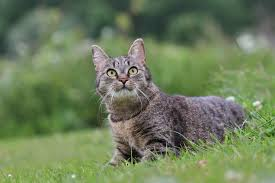

In [6]:
# Display the first loaded image
images[0]

## Step 4 – Load Dataset Statistics
We need class names to interpret predictions,
and dataset mean/std to normalize images consistently
with model training.

In [7]:
# Load normalization statistics from training
stats_path = os.path.join(f"data/{dataset}", "stats.json")
with open(stats_path, "r", encoding="utf-8") as f:
    stats = json.load(f)

mean = stats['mean']
std = stats['std']

In [8]:
# Define the preprocessing transform
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

## Step 5 – Preprocess Images and Build a Batch
Each image is converted to RGB, transformed, normalized,
and added into a single PyTorch batch tensor.

In [9]:
batch = []
for img in images:
    img = img.convert("RGB")
    tensor = transform(img)
    batch.append(tensor)

# Stack into a batch and move to GPU
batch = torch.stack(batch).to('cuda')

## Step 6 – Run Inference and Print Top-1 Predictions
The model outputs probabilities for each class. We take
the predicted class (top-1) and print confidence scores.

In [10]:
probs = model.predict(batch, return_probs=True)

top1 = torch.argmax(probs, dim=1)

In [11]:
for i, img in enumerate(images):
    predicted_class = class_names[top1[i].item()]
    confidence = probs[i][top1[i]].item()

    print(f"Image {i}: {predicted_class} ({confidence:.2f})")

Image 0: deer (0.84)
Image 1: airplane (0.43)
Image 2: dog (0.84)
Image 3: cat (0.46)
Image 4: bird (0.28)
Image 5: cat (0.50)
Image 6: deer (0.75)
Image 7: frog (0.50)


## Step 7 – Visualize Images with Top-1 Predictions

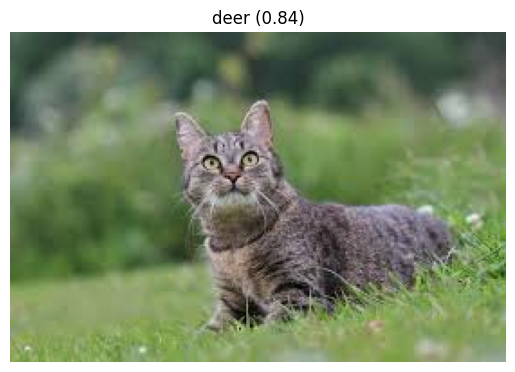

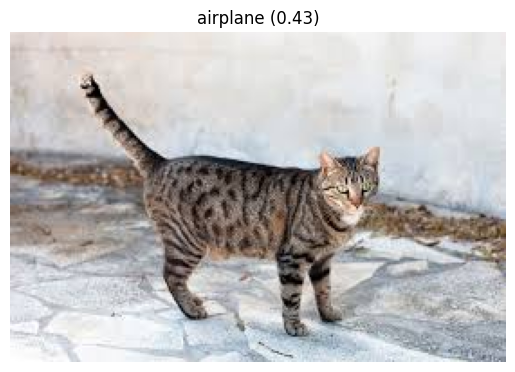

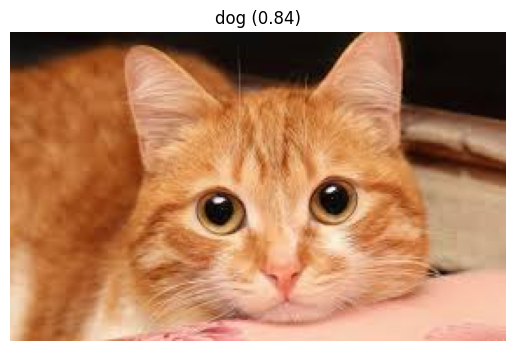

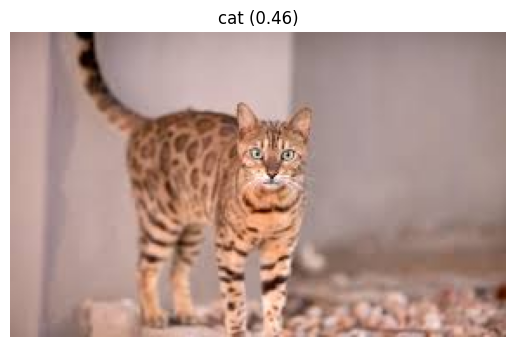

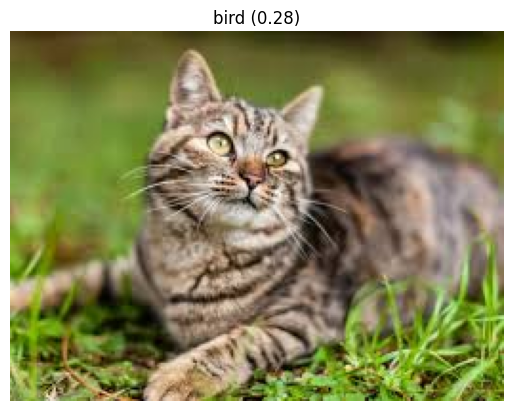

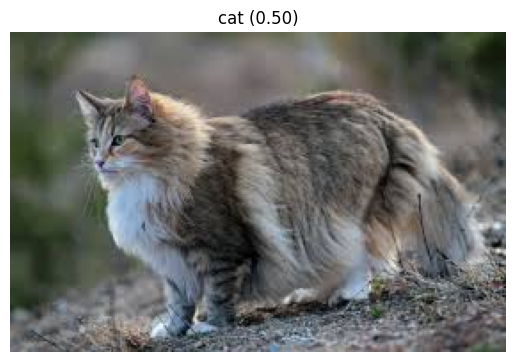

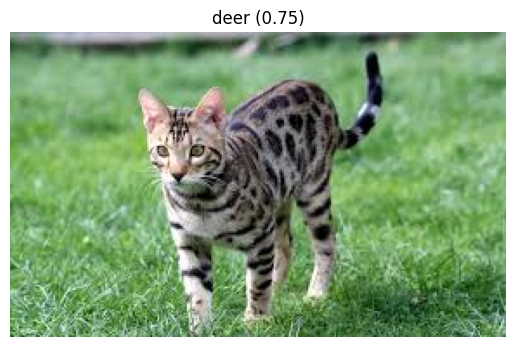

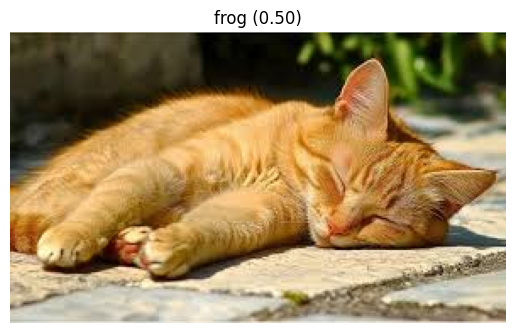

In [12]:
for i, img in enumerate(images):
    plt.imshow(img)
    plt.title(f"{class_names[top1[i].item()]} ({probs[i][top1[i]].item():.2f})")
    plt.axis("off")
    plt.show()

## Step 8 – Visualize Images with Top-3 Predictions
We display the three most likely classes for each image,
which helps assess model confidence and uncertainty.

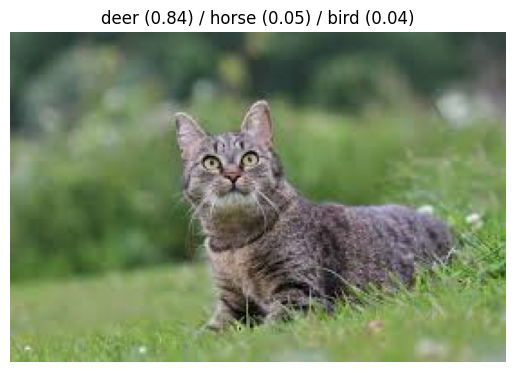

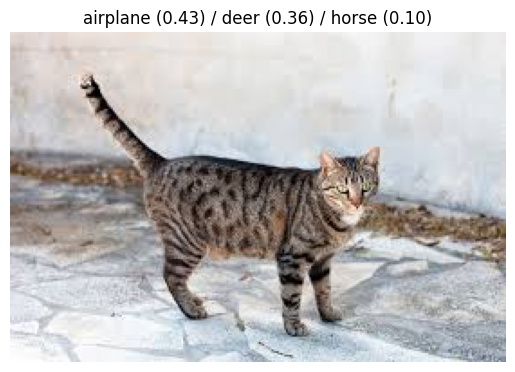

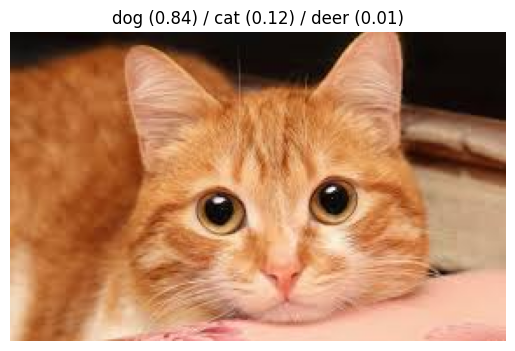

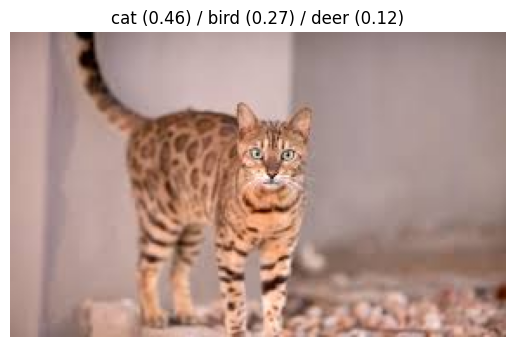

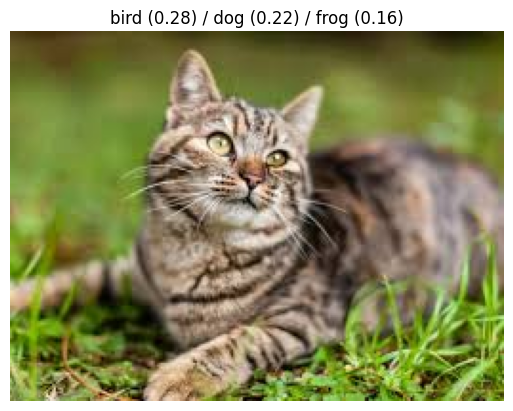

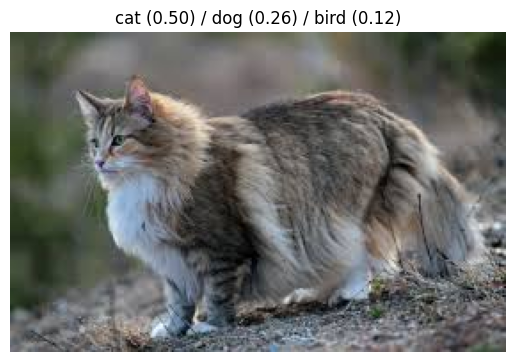

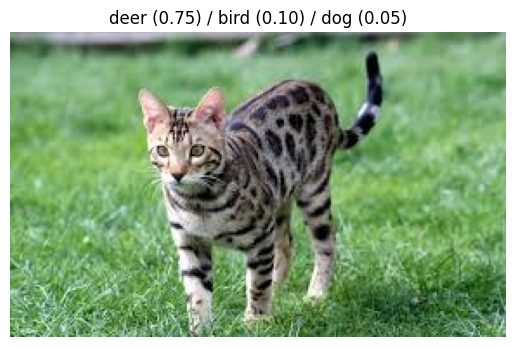

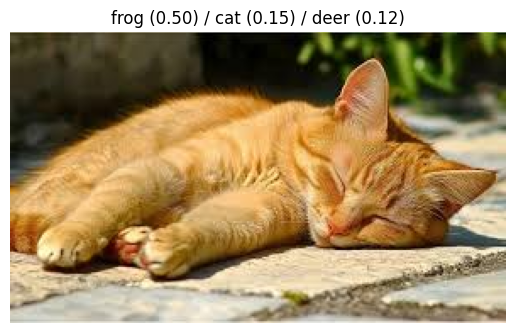

In [13]:
top3_probs, top3_indices = probs.topk(3, dim=1)

for i, img in enumerate(images):
    labels = [
        f"{class_names[top3_indices[i][k].item()]} ({top3_probs[i][k].item():.2f})"
        for k in range(3)
    ]
    title = " / ".join(labels)

    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


## Grad Cam

In [14]:
from core.gradcam import GradCAM, overlay_heatmap
import cv2

In [15]:
# 2. Récupérer la target layer via notre nouvelle méthode
target_layer = model.get_target_layer()

# 3. Initialiser Grad-CAM
grad_cam = GradCAM(model=model, target_layer=target_layer)

c:\Users\Léo\Documents\Python\pytorch\lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


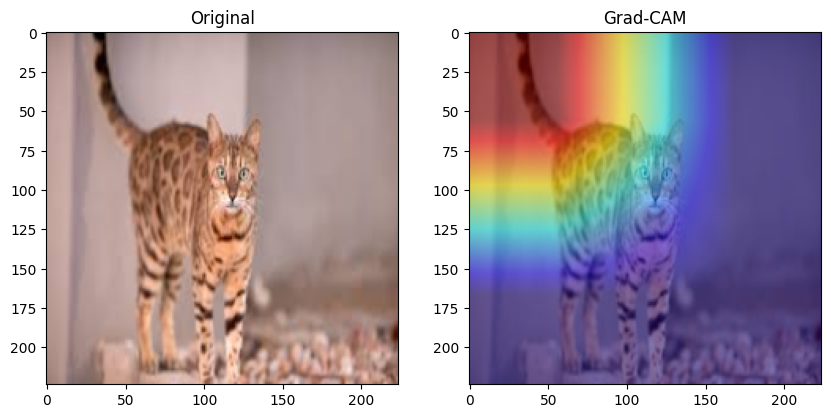

In [16]:
# 4. Charger une image
img_path = "data/CINIC-10/train/cat/cifar10-train-740.png" # Exemple
img_path = "data/example/train/cat/cat4.jpg" # Exemple
pil_img = Image.open(img_path).convert('RGB')

# Prétraitement (Même que pour l'entrainement !)
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
input_tensor = preprocess(pil_img).unsqueeze(0).to("cuda") # (1, 3, 32, 32)

# 5. Générer la heatmap
# target_class=None -> prédit automatiquement la classe la plus probable
# target_class=3 -> force l'explication pour la classe "chat" (index 3 par ex)
mask = grad_cam.generate(input_tensor, target_class=None)

# 6. Visualisation
# On charge l'image originale pour la superposition
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (224, 224)) # Plus grand pour voir mieux

# On redimensionne le masque à 224x224 pour l'affichage joli
mask_resized = cv2.resize(mask, (224, 224))

heatmap_img = overlay_heatmap(img_path, mask_resized)

# Affichage Matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.show()